In [222]:
!pip install category-encoders
!pip install catboost
!pip install optuna

In [223]:
import pandas as pd
import numpy as np
import random
import os
import warnings

from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

import optuna
from optuna.samplers import TPESampler

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [224]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [225]:
# #그래프 한글 출력을 위함
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# plt.rc('font', family='NanumBarunGothic')
# plt.rcParams['axes.unicode_minus'] = False

# #colab 실행시 위 코드 실행 후 런타임 세션 다시 시작하고 다시 실행

In [226]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

test_copy = test.copy()

Min Income: 0, Max Income: 9999


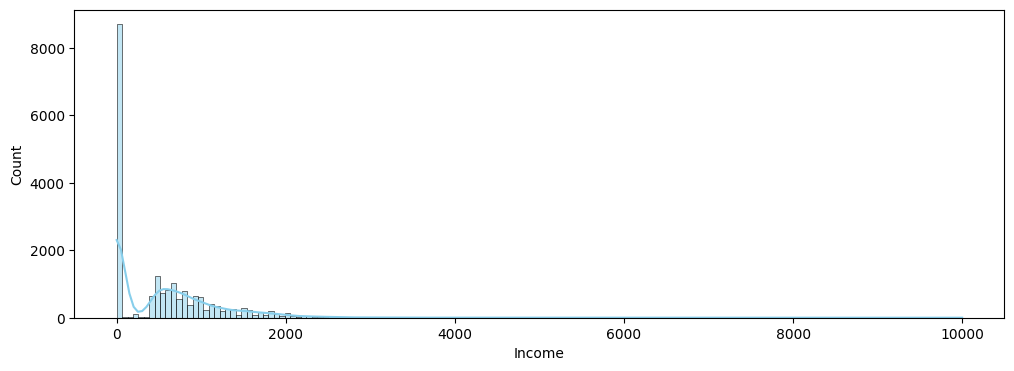

In [227]:
# Income 분포 확인
print(f'Min Income: {train["Income"].min()}, Max Income: {train["Income"].max()}')

plt.figure(figsize=(12, 4))

data = train['Income']

sns.histplot(data, color='skyblue', kde=True)
plt.xlabel('Income')
plt.show()

In [228]:
# Age가 20보다 작은 경우 Income 평균
train[train['Age'] < 20].groupby('Age')['Income'].mean().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.000000,16.000000,17.000000,18.000000,19.000000
Income,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.053691,243.922509,308.148148,381.249322,459.005571


In [229]:
# Age가 80 이상인 경우 Income 평균
train[train['Age'] >= 80].groupby('Age')['Income'].mean().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10
Age,80.000000,81.000000,82.000000,83.0,84.0,85.0,86.000000,87.0,88.0,89.0,90.00
Income,21.808511,15.384615,26.923077,0.0,0.0,0.0,61.904762,0.0,0.0,0.0,120.56


In [230]:
# Employment_Status별 Income 평균
train.groupby('Employment_Status')['Income'].mean().reset_index()

,Employment_Status,Income
0,Children or Armed Forces,488.226979
1,Choice Part-Time,792.866779
2,Full-Time,746.928051
3,Not Working,0.000000
4,Part-Time (Usually Full-Time),757.970000
5,Part-Time (Usually Part-Time),877.905063
6,Seeking Full-Time,146.595041
7,Seeking Part-Time,367.584416


In [231]:
# Occupation_Status별 Income 평균
train.groupby('Occupation_Status')['Income'].mean().reset_index()

,Occupation_Status,Income
0,Admin Support (include Clerical),750.374677
1,Armed Forces,0.000000
2,Craft & Repair,986.415730
3,Farming & Forestry & Fishing,477.922297
4,Handlers/Cleaners,655.152927
5,Machine Operators & Inspectors,802.055676
6,Management,619.179118
7,Private Household Services,420.857143
8,Professional,884.705645
9,Protective Services,823.511538


In [232]:
# Industry_Status별 Income 평균
train.groupby('Industry_Status')['Income'].mean().reset_index()

,Industry_Status,Income
0,Agriculture,434.630597
1,Armed Forces,0.000000
2,Business & Repair,646.846517
3,Communications,952.835897
4,Construction,887.155048
5,Education,616.393852
6,Entertainment,703.643885
7,Finance Insurance & Real Estate,625.617607
8,Forestry & Fisheries,592.038462
9,Hospitals,1040.193666


In [233]:
# Education_Status별 Income 평균
train.groupby('Education_Status')['Income'].mean().reset_index()

,Education_Status,Income
0,Associates degree (Academic),782.740558
1,Associates degree (Vocational),867.269906
2,Bachelors degree,699.367076
3,Children,0.000000
4,College,651.468108
5,Doctorate degree,575.528736
6,Elementary (1-4),343.440000
7,Elementary (5-6),325.116719
8,High Freshman,366.794595
9,High Junior,483.034146


In [234]:
train = train[(train['Age'] >= 15) & (train['Income'] <= 3000)]
train = train[train['Employment_Status']!='Not Working']
train = train[train['Occupation_Status']!='Armed Forces']
train = train[train['Occupation_Status']!='Unknown']
train = train[train['Industry_Status']!='Armed Forces']
train = train[train['Industry_Status']!='Not in universe or children']
train = train[train['Education_Status']!='Children']

test = test[test['Age'] >= 15]
test = test[test['Employment_Status']!='Not Working']
test = test[test['Occupation_Status']!='Armed Forces']
test = test[test['Occupation_Status']!='Unknown']
test = test[test['Industry_Status']!='Armed Forces']
test = test[test['Industry_Status']!='Not in universe or children']
test = test[test['Education_Status']!='Children']

test_ID = test['ID']

In [235]:
# 불필요한 컬럼 제거
drop_cols = ['ID']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

# 중복 데이터 제거
before_train_size = train.shape[0]
train = train.drop_duplicates()
print(f'중복 데이터 제거 개수 : {before_train_size - train.shape[0]}')
train.reset_index(drop=True, inplace=True)

중복 데이터 제거 개수 : 12


In [236]:
# Target Encoding
object_columns = train.select_dtypes(include='object').columns

for i in object_columns:
    le = TargetEncoder()
    train[i] = le.fit_transform(train[i], train['Income'])
    test[i] = le.transform(test[i])

In [237]:
# 파생변수 생성
train['Industry_Occupation'] = train['Industry_Status'] * train['Occupation_Status']
train['Age_Household_Size_Ratio'] = train['Age'] / train['Household_Summary']
train['Race_Gender'] = train['Race'] * train['Gender']
train['Race_Hispanic_Origin'] = train['Race'] * train['Hispanic_Origin']

test['Industry_Occupation'] = test['Industry_Status'] * test['Occupation_Status']
test['Age_Household_Size_Ratio'] = test['Age'] / test['Household_Summary']
test['Race_Gender'] = test['Race'] * test['Gender']
test['Race_Hispanic_Origin'] = test['Race'] * test['Hispanic_Origin']

In [238]:
def skf_train_model(train, estimators):
    X = train.copy()
    y = X.pop('Income')

    test_predictions = np.zeros((len(test))) # 예측을 누적할 배열
    val_scores = [] # 각 폴드에서의 검증 세트에 대한 평가 성능을 저장할 리스트

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        model = clone(estimators)

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)

        train_y_pred = model.predict(X_train)
        valid_y_pred = model.predict(X_valid)

        # print(f"Train RMSE Score : {mean_squared_error(y_train, train_y_pred, squared=False)}")
        # print(f"Valid RMSE Score : {mean_squared_error(y_valid, valid_y_pred, squared=False)}")
        # print("-" * 50)

        test_predictions += model.predict(test) / 5
        y_preds = model.predict(X_valid)
        val_scores.append(mean_squared_error(y_valid, y_preds, squared=False))

    # print(f"RMSE Score : {np.array(val_scores).mean()}")

    return val_scores, test_predictions

In [239]:
best_params = {
    'num_leaves': 50,
    'max_depth': 8,
    'learning_rate': 0.06996742850657808,
    'n_estimators': 107,
    'min_child_samples': 21,
    'subsample': 0.5889374661414168,
    'colsample_bytree': 0.3306647854340129,
    'reg_alpha': 2.814245208464249,
    'reg_lambda': 9.238104977329753
}

best_params["random_state"] = 293
best_params["verbosity"] = -1

lgbm = LGBMRegressor(**best_params)

In [240]:
lgbm_val_scores, lgbm_test_predictions = skf_train_model(train, lgbm)

In [241]:
submission.loc[submission['ID'].isin(test_ID), 'Income'] = lgbm_test_predictions

In [242]:
final = pd.concat([test_copy, submission[['Income']]], axis=1)

In [243]:
final.loc[final['Employment_Status'] == 'Seeking Full-Time', 'Income'] = 0
final.loc[(final['Age'] >= 83) & (final['Age'] < 90), 'Income'] = 0
final.loc[final['Income'] <= 200, 'Income'] = 0

In [244]:
submission['Income'] = final['Income']

In [245]:
submission.to_csv("submission_19.csv", index=False)